# Q1

In [1]:
# get data
from google.colab import drive
drive.mount('/mnt/drive')

import pandas as pd
df = pd.read_csv('/mnt/drive/MyDrive/ece219/Project1-ClassificationDataset.csv')

Mounted at /mnt/drive


In [2]:
rows, columns = df.shape[0], df.shape[1]
print(f'Rows: {rows}')
print(f'Columns: {columns}')

df.head()

Rows: 3476
Columns: 8


,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,'Personalize Your NBA App Experience for the '...,'Personalize Your NBA App Experience for the '...,"['original', 'content', 'live', 'slate', 'game...",NaN,['Official Release'],https://www.nba.com/news/nba-app-new-features-...,basketball,sports
1,'Mike Will attends the Pre-GRAMMY Gala and GRA...,'Mike WiLL Made-It has secured a partnership w...,"['lead', 'espn', 'nbas', 'madeit', 'nba', 'lat...",2023-10-18 16:22:29+00:00,['Marc Griffin'],https://www.vibe.com/news/entertainment/mike-w...,basketball,sports
2,'The Golden State Warriors are struggling to f...,'The Golden State Warriors are struggling to f...,"['insider', 'york', 'thing', 'nbc', 'tag', 'nb...",NaN,[],https://www.nbcnewyork.com/tag/featured-nba/,basketball,sports
3,"'On Nov. 28, the NBA and Nike will collaborate...","'On Nov. 28, the NBA and Nike will collaborate...","['watch', 'telecast', 'ultimate', 'membership'...",NaN,['Official Release'],https://www.nba.com/news/watch-nba-games-ultim...,basketball,sports
4,'The NBA announced additions and innovations t...,'The NBA announced additions and innovations t...,"['experience', 'bring', 'media', 'crennan', 'n...",2023-10-17 12:00:17+00:00,"['Chris Novak', 'About Chris Novak']",https://awfulannouncing.com/tech/nba-app-2023-...,basketball,sports


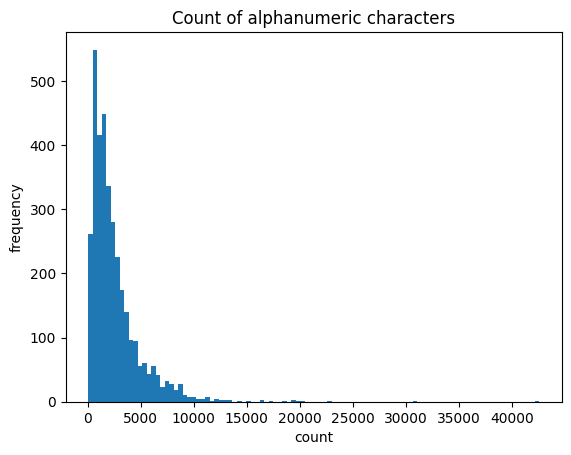

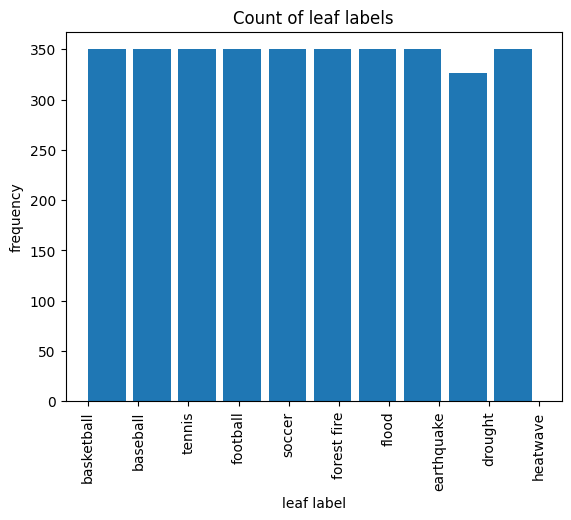

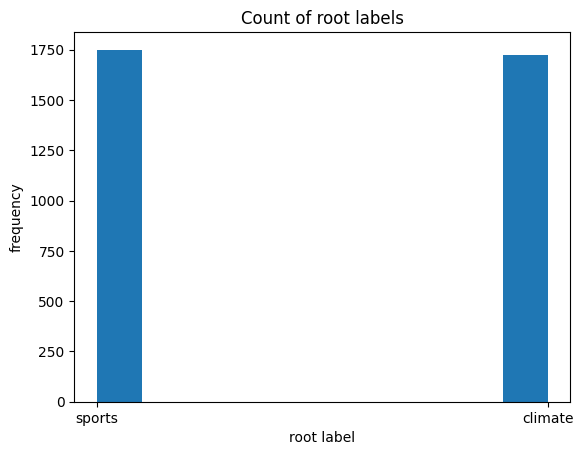

In [3]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

count = df['full_text'].str.findall(r'[a-zA-Z0-9]').str.len()
plt.hist(list(count), bins=100)
plt.xticks(np.arange(0, 45000, 5000))
plt.title('Count of alphanumeric characters')
plt.xlabel('count')
plt.ylabel('frequency')
plt.show()

plt.hist(df['leaf_label'].tolist(), width=0.75)
plt.xticks(rotation=90)
plt.title('Count of leaf labels')
plt.xlabel('leaf label')
plt.ylabel('frequency')
plt.show()

plt.hist(df['root_label'].tolist())
plt.title('Count of root labels')
plt.xlabel('root label')
plt.ylabel('frequency')
plt.show()

# Q2

In [4]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)

print(f'Number of training samples: {train.shape[0]}\nNumber of testing samples: {test.shape[0]}')

Number of training samples: 2780
Number of testing samples: 696


# Q3

In [6]:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

train = train.map(clean)
test = test.map(clean)

print(f'Number of training samples: {train.shape[0]}\nNumber of testing samples: {test.shape[0]}')

Number of training samples: 2780
Number of testing samples: 696


In [7]:
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [8]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from nltk import pos_tag, wordnet
from nltk.corpus import stopwords
from string import punctuation

# lemmatizer
wnl = wordnet.WordNetLemmatizer()

# from helper_code
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

# from helper_code
def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(list_word)]

analyzer = CountVectorizer().build_analyzer()

# get custom stop words, for filtering after lemmatization
# from helper_code
stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

# exclude word that are all numbers
def is_all_numbers(word):
    for char in word:
        # if character is not a number / negative sign / decimal point
        if not char.isdigit() and char != '-' and char != '.':
            return False
    return True

# from helper_code
def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not is_all_numbers(word))

vectorizer = CountVectorizer(analyzer=stem_rmv_punc,
                             stop_words='english',
                             min_df=3)

In [9]:
train_lemmatized = vectorizer.fit_transform(train['full_text'])
test_lemmatized = vectorizer.transform(test['full_text'])

print('Lemmatized train shape')
print(f'Rows: {train_lemmatized.shape[0]}')
print(f'Columns: {train_lemmatized.shape[1]}')

print('Lemmatized test shape')
print(f'Rows: {test_lemmatized.shape[0]}')
print(f'Columns: {test_lemmatized.shape[1]}')

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


Lemmatized train shape
Rows: 2780
Columns: 13288
Lemmatized test shape
Rows: 696
Columns: 13288


In [10]:
from sklearn.feature_extraction.text import TfidfTransformer

# process using tfidf
tfidf_transformer = TfidfTransformer()

train_tfidf = tfidf_transformer.fit_transform(train_lemmatized)
test_tfidf = tfidf_transformer.transform(test_lemmatized)

print('Train TFIDF shape')
print(f'Rows: {train_tfidf.shape[0]}')
print(f'Columns: {train_tfidf.shape[1]}')

print('Test TFIDF shape')
print(f'Rows: {test_tfidf.shape[0]}')
print(f'Columns: {test_tfidf.shape[1]}')

Train TFIDF shape
Rows: 2780
Columns: 13288
Test TFIDF shape
Rows: 696
Columns: 13288


# Q4

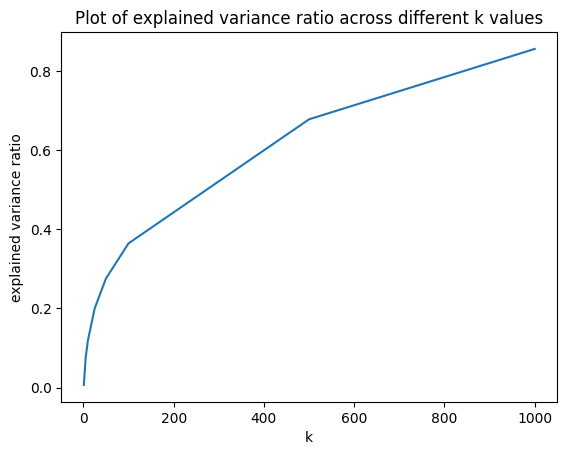

In [11]:
# Dimensionality reduction
from sklearn.decomposition import TruncatedSVD

# LSI
k_values = [1, 5, 10, 25, 50, 100, 500, 1000]
evr = []
for k in k_values:
    svd = TruncatedSVD(n_components=k, random_state=42)
    svd.fit_transform(train_tfidf)
    evr.append(svd.explained_variance_ratio_.sum())

plt.plot(k_values, evr)
plt.title('Plot of explained variance ratio across different k values')
plt.xlabel('k')
plt.ylabel('explained variance ratio')
plt.show()

In [12]:
# NMF error
from sklearn.decomposition import NMF

model = NMF(n_components=25, init='random', random_state=42)
W_train = model.fit_transform(train_tfidf)
H = model.components_
nmf_error = np.sum(np.array(train_tfidf - W_train.dot(H))**2)
print(f'NMF error: {nmf_error}')

NMF error: 2170.586363338054


In [13]:
# LSI error
# based on https://stackoverflow.com/a/54339338

svd = TruncatedSVD(n_components=25, random_state=42)
USigma = svd.fit_transform(train_tfidf)
VT = svd.components_
lsi_error = np.sum(np.array(train_tfidf - USigma.dot(VT))**2)
print(f'LSI error: {lsi_error}')

LSI error: 2152.4526721780967


# Q5

In [14]:
# first implement LSI
svd = TruncatedSVD(n_components=25, random_state=42)
train_lsi = svd.fit_transform(train_tfidf)
test_lsi = svd.transform(test_tfidf)

In [43]:
# Plot ROC and obtain metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# from helper code
def plot_roc(fpr, tpr, pipe_title):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    subplot_title = f'ROC curve for {pipe_title}'
    ax.title.set_text(subplot_title)
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

# from helper code
def fit_predict_and_show_stats(pipe, train_data, train_label, test_data, test_label, pipe_title):
    change_to_num = np.vectorize(lambda x: 0 if x=='sports' else 1)
    new_train_label = change_to_num(train_label)
    new_test_label = change_to_num(test_label)

    pipe.fit(train_data, new_train_label)
    predicted = pipe.predict(test_data)

    prob_score = pipe.predict_proba(test_data)
    fpr, tpr, _ = roc_curve(new_test_label, prob_score[:,1])

    # Plot ROC
    plot_roc(fpr, tpr, pipe_title)

    # Report stats
    print('----------')
    print(f"Stats for {pipe_title}")
    print(f"Confusion matrix:\n{confusion_matrix(new_test_label, predicted)}")
    print(f"Accuracy score: {accuracy_score(new_test_label, predicted)}")
    print(f"Recall score: {recall_score(new_test_label, predicted)}")
    print(f"Precision score: {precision_score(new_test_label, predicted)}")
    print(f"F1 score: {f1_score(new_test_label, predicted)}")
    print('----------')
    print()

----------
Stats for svm_hard (gamma=2000)
Confusion matrix:
[[348  20]
 [ 19 309]]
Accuracy score: 0.9439655172413793
Recall score: 0.9420731707317073
Precision score: 0.939209726443769
F1 score: 0.9406392694063926
----------

----------
Stats for svm_soft (gamma=0.0005)
Confusion matrix:
[[  0 368]
 [  0 328]]
Accuracy score: 0.47126436781609193
Recall score: 1.0
Precision score: 0.47126436781609193
F1 score: 0.640625
----------

----------
Stats for svm_veryhard (gamma=100000)
Confusion matrix:
[[348  20]
 [ 19 309]]
Accuracy score: 0.9439655172413793
Recall score: 0.9420731707317073
Precision score: 0.939209726443769
F1 score: 0.9406392694063926
----------



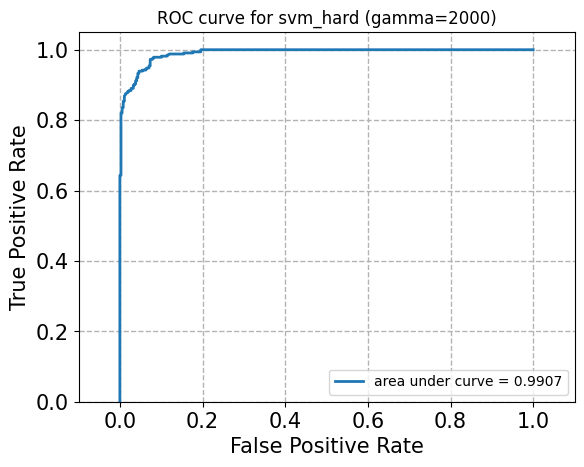

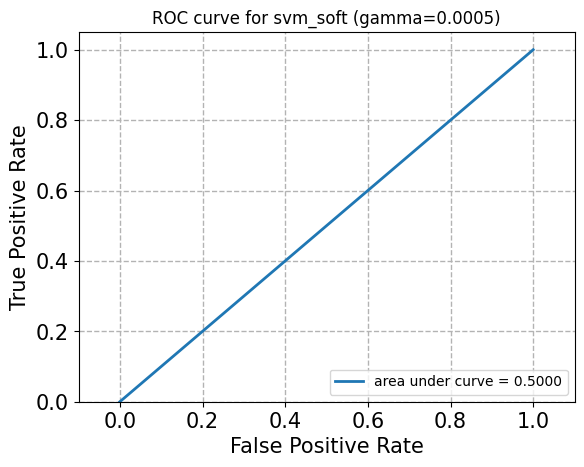

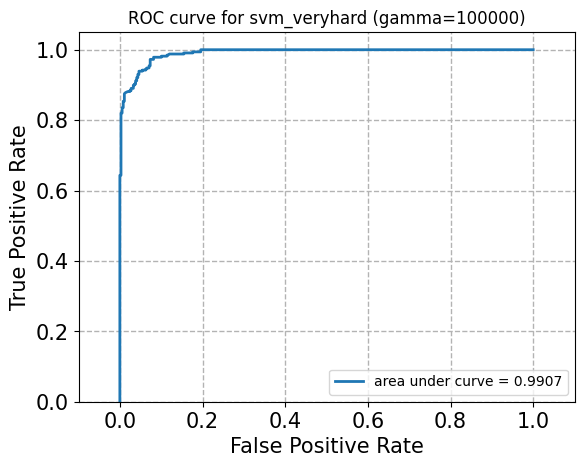

In [44]:
# Linear SVM
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# create pipelines
svm_hard_pipe = Pipeline([
    ('clf', SVC(kernel='linear', C=2000, probability=True)),
])
svm_soft_pipe = Pipeline([
    ('clf', SVC(kernel='linear', C=0.0005, probability=True)),
])
svm_veryhard_pipe = Pipeline([
    ('clf', SVC(kernel='linear', C=100000, probability=True)),
])

pipes = [svm_hard_pipe, svm_soft_pipe, svm_veryhard_pipe]
pipe_name = ['svm_hard (gamma=2000)', 'svm_soft (gamma=0.0005)', 'svm_veryhard (gamma=100000)']

for i in range(len(pipes)):
    fit_predict_and_show_stats(pipes[i], train_lsi, train['root_label'], test_lsi, test['root_label'], pipe_name[i])

In [45]:
# Cross validation

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

k_vals = np.arange(-3, 7, 1)
gammas = np.float_power(10, k_vals)

best_score = -1
for gamma in gammas:
    clf = SVC(kernel='linear', C=gamma, probability=True)
    score = np.mean(cross_val_score(clf, train_lsi, train['root_label'], cv=5, scoring='accuracy'))
    if score > best_score:
        best_score = score
        best_gamma = gamma

print(f'Best gamma: {best_gamma}\nwith best average accuracy: {best_score}')

Best gamma: 100.0
with best average accuracy: 0.9546762589928057


----------
Stats for best SVM (gamma=100.0)
Confusion matrix:
[[348  20]
 [ 19 309]]
Accuracy score: 0.9439655172413793
Recall score: 0.9420731707317073
Precision score: 0.939209726443769
F1 score: 0.9406392694063926
----------



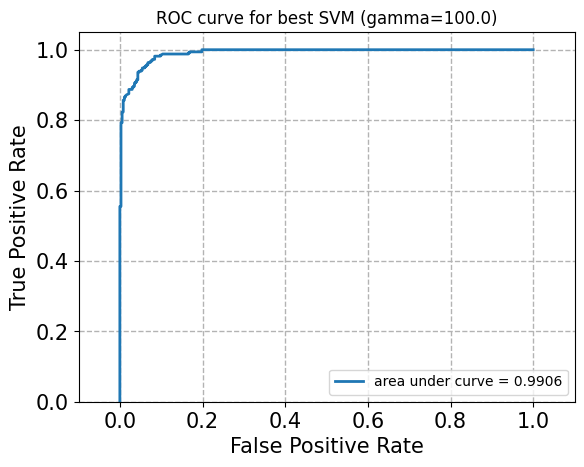

In [46]:
# Best SVM

svm_best_pipe = Pipeline([
    ('clf', SVC(kernel='linear', C=best_gamma, probability=True)),
])

fit_predict_and_show_stats(svm_best_pipe, train_lsi, train['root_label'], test_lsi, test['root_label'], f'best SVM (gamma={best_gamma})')

# Q6

----------
Stats for logistic regression without regularization
Confusion matrix:
[[348  20]
 [ 18 310]]
Accuracy score: 0.9454022988505747
Recall score: 0.9451219512195121
Precision score: 0.9393939393939394
F1 score: 0.9422492401215805
----------



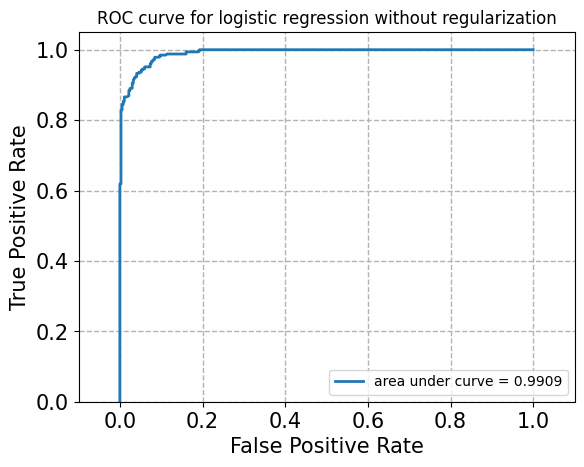

In [47]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

lr_pipe = Pipeline([
    ('clf', LogisticRegression(penalty=None)),
])

fit_predict_and_show_stats(lr_pipe, train_lsi, train['root_label'], test_lsi, test['root_label'], 'logistic regression without regularization')

In [48]:
logistic_k_vals = np.arange(-5, 6, 1)
reg_strengths = np.float_power(10, logistic_k_vals)

best_l1_score = -1
for reg_strength in reg_strengths:
    clf = LogisticRegression(penalty='l1', C=1/reg_strength, solver='liblinear')
    score = np.mean(cross_val_score(clf, train_lsi, train['root_label'], cv=5, scoring='accuracy'))
    if score > best_l1_score:
        best_l1_score = score
        best_l1_reg_strength = reg_strength

best_l2_score = -1
for reg_strength in reg_strengths:
    clf = LogisticRegression(penalty='l2', C=1/reg_strength)
    score = np.mean(cross_val_score(clf, train_lsi, train['root_label'], cv=5, scoring='accuracy'))
    if score > best_l2_score:
        best_l2_score = score
        best_l2_reg_strength = reg_strength

print(f'Best L1 regularization strength: {best_l1_reg_strength}\nwith best average accuracy: {best_l1_score}')
print(f'Best L2 regularization strength: {best_l2_reg_strength}\nwith best average accuracy: {best_l2_score}')

Best L1 regularization strength: 0.01
with best average accuracy: 0.952158273381295
Best L2 regularization strength: 1e-05
with best average accuracy: 0.9521582733812949


----------
Stats for best L1 logistic regression (reg strength=0.01)
Confusion matrix:
[[349  19]
 [ 19 309]]
Accuracy score: 0.9454022988505747
Recall score: 0.9420731707317073
Precision score: 0.9420731707317073
F1 score: 0.9420731707317073
----------

----------
Stats for best L2 logistic regression (reg strength=1e-05)
Confusion matrix:
[[348  20]
 [ 18 310]]
Accuracy score: 0.9454022988505747
Recall score: 0.9451219512195121
Precision score: 0.9393939393939394
F1 score: 0.9422492401215805
----------



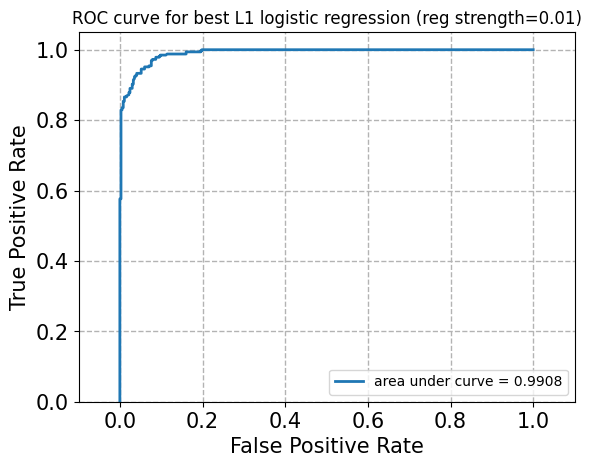

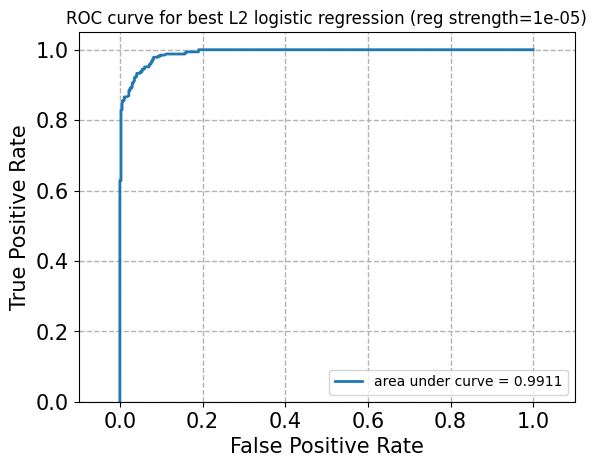

In [49]:
# Best Logistic Regression

lr_l1_best_pipe = Pipeline([
    ('clf', LogisticRegression(penalty='l1', C=1/best_l1_reg_strength, solver='liblinear')),
])
lr_l2_best_pipe = Pipeline([
    ('clf', LogisticRegression(penalty='l2', C=1/best_l2_reg_strength)),
])

fit_predict_and_show_stats(lr_l1_best_pipe, train_lsi, train['root_label'], test_lsi, test['root_label'], f'best L1 logistic regression (reg strength={best_l1_reg_strength})')
fit_predict_and_show_stats(lr_l2_best_pipe, train_lsi, train['root_label'], test_lsi, test['root_label'], f'best L2 logistic regression (reg strength={best_l2_reg_strength})')

# Q7

----------
Stats for naive bayes
Confusion matrix: [[280  48]
 [ 11 357]]
Accuracy score: 0.9152298850574713
Recall score: 0.970108695652174
Precision score: 0.8814814814814815
F1 score: 0.9236739974126779
----------



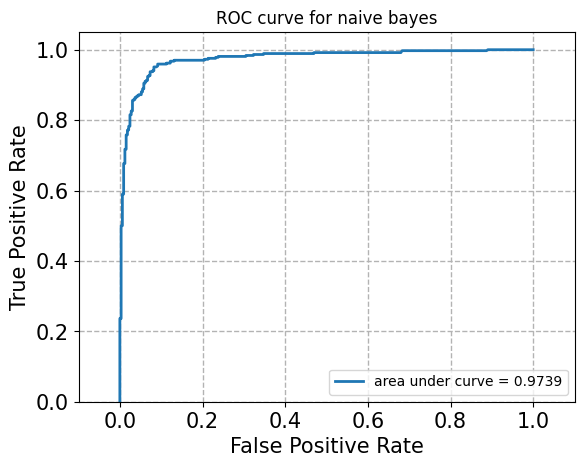

In [ ]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

nb_pipe = Pipeline([
    ('clf', GaussianNB()),
])

fit_predict_and_show_stats(nb_pipe, train_lsi, train['root_label'], test_lsi, test['root_label'], 'naive bayes')

# Q8

In [ ]:
# GridSearch

# we construct the pipelines, but place the data loading, feature extraction and dimensionality reduction parts outside of the pipeline

# from helper_code
stemmer = nltk.stem.PorterStemmer()
def stemmed_words(doc):
    return (stemmer.stem(word) for word in analyzer(doc) if not is_all_numbers(word))

# returns feature-extracted train and test data
def build_feature_extraction_service(fe_method, min_df):
    if fe_method == "lemmatization":
        vectorizer = CountVectorizer(analyzer=stem_rmv_punc, stop_words='english', min_df=min_df)
    else:
        vectorizer = CountVectorizer(analyzer=stemmed_words, stop_words='english', min_df=min_df)

    new_train = vectorizer.fit_transform(train['full_text'])
    new_test = vectorizer.transform(test['full_text'])

    # process tf-idf
    tfidf_transformer = TfidfTransformer()
    train_tfidf = tfidf_transformer.fit_transform(new_train)
    test_tfidf = tfidf_transformer.transform(new_test)
    return train_tfidf, test_tfidf

# define combinations
fe_combinations = [
    {"fe_method": "stemming", "min_df": 2},
    {"fe_method": "stemming", "min_df": 5},
    {"fe_method": "lemmatization", "min_df": 2},
    {"fe_method": "lemmatization", "min_df": 5},
]

# from helper code
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('reduce_dim', "passthrough"),
    ('clf', "passthrough"),
])

param_grid = [
    {
        'reduce_dim': [TruncatedSVD(random_state=42), NMF(init='random', random_state=42)],
        'reduce_dim__n_components': [5, 30, 100],
        'clf': [SVC(kernel='linear', C=best_gamma, probability=True),
                LogisticRegression(penalty='l1', C=1/best_l1_reg_strength, solver='liblinear'),
                LogisticRegression(penalty='l2', C=1/best_l2_reg_strength),
                GaussianNB()],
    }
]

scores = []
for fe_config in fe_combinations:
    fe_train, fe_test = build_feature_extraction_service(fe_config.get("fe_method"), fe_config.get("min_df"))

    grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
    grid.fit(fe_train, train['root_label'])

    mean_test_score = [(grid.cv_results_['mean_test_score'][i], i) for i in range(len(grid.cv_results_['mean_test_score']))]
    mean_test_score.sort(key=lambda x: x[0], reverse=True)

    for i in range(5):
        idx = mean_test_score[i][1]
        scores.append((mean_test_score[i][0], {**fe_config, **grid.cv_results_['params'][idx]}))

    scores.sort(key=lambda x: x[0], reverse=True)
    print(f'Finished {fe_config}. Current scores:\n{scores}\n----------\n')

top_5_scores = scores[:5]
print(f'Top 5 scores\n{top_5_scores}')

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

Finished {'fe_method': 'stemming', 'min_df': 2}. Current scores:
[(0.9600719424460433, {'fe_method': 'stemming', 'min_df': 2, 'clf': SVC(C=100.0, kernel='linear', probability=True), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}), (0.9589928057553957, {'fe_method': 'stemming', 'min_df': 2, 'clf': LogisticRegression(C=100.0, penalty='l1', solver='liblinear'), 'reduce_dim': NMF(init='random', random_state=42), 'reduce_dim__n_components': 100}), (0.9589928057553957, {'fe_method': 'stemming', 'min_df': 2, 'clf': LogisticRegression(C=99999.99999999999), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}), (0.9579136690647484, {'fe_method': 'stemming', 'min_df': 2, 'clf': LogisticRegression(C=100.0, penalty='l1', solver='liblinear'), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}), (0.9553956834532376, {'fe_method': 'stemming', 'min_df': 2, 'clf': LogisticRegression(C=99999.99999999999), 'reduce_dim': NM

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

Finished {'fe_method': 'stemming', 'min_df': 5}. Current scores:
[(0.9622302158273381, {'fe_method': 'stemming', 'min_df': 5, 'clf': LogisticRegression(C=100.0, penalty='l1', solver='liblinear'), 'reduce_dim': NMF(init='random', random_state=42), 'reduce_dim__n_components': 100}), (0.9611510791366907, {'fe_method': 'stemming', 'min_df': 5, 'clf': LogisticRegression(C=99999.99999999999), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}), (0.9600719424460433, {'fe_method': 'stemming', 'min_df': 2, 'clf': SVC(C=100.0, kernel='linear', probability=True), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}), (0.9589928057553957, {'fe_method': 'stemming', 'min_df': 2, 'clf': LogisticRegression(C=100.0, penalty='l1', solver='liblinear'), 'reduce_dim': NMF(init='random', random_state=42), 'reduce_dim__n_components': 100}), (0.9589928057553957, {'fe_method': 'stemming', 'min_df': 2, 'clf': LogisticRegression(C=99999.99999999999), 'reduce_di

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklea

Finished {'fe_method': 'lemmatization', 'min_df': 2}. Current scores:
[(0.9651079136690646, {'fe_method': 'lemmatization', 'min_df': 2, 'clf': LogisticRegression(C=100.0, penalty='l1', solver='liblinear'), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}), (0.9633093525179856, {'fe_method': 'lemmatization', 'min_df': 2, 'clf': LogisticRegression(C=99999.99999999999), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}), (0.9629496402877697, {'fe_method': 'lemmatization', 'min_df': 2, 'clf': SVC(C=100.0, kernel='linear', probability=True), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}), (0.9622302158273381, {'fe_method': 'stemming', 'min_df': 5, 'clf': LogisticRegression(C=100.0, penalty='l1', solver='liblinear'), 'reduce_dim': NMF(init='random', random_state=42), 'reduce_dim__n_components': 100}), (0.9622302158273381, {'fe_method': 'lemmatization', 'min_df': 2, 'clf': LogisticRegression(C=100.0, pena

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/decompo

Finished {'fe_method': 'lemmatization', 'min_df': 5}. Current scores:
[(0.9661870503597122, {'fe_method': 'lemmatization', 'min_df': 5, 'clf': LogisticRegression(C=100.0, penalty='l1', solver='liblinear'), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}), (0.9658273381294965, {'fe_method': 'lemmatization', 'min_df': 5, 'clf': LogisticRegression(C=100.0, penalty='l1', solver='liblinear'), 'reduce_dim': NMF(init='random', random_state=42), 'reduce_dim__n_components': 100}), (0.9651079136690646, {'fe_method': 'lemmatization', 'min_df': 2, 'clf': LogisticRegression(C=100.0, penalty='l1', solver='liblinear'), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}), (0.9636690647482015, {'fe_method': 'lemmatization', 'min_df': 5, 'clf': LogisticRegression(C=99999.99999999999), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}), (0.9633093525179856, {'fe_method': 'lemmatization', 'min_df': 2, 'clf': LogisticRegre

In [ ]:
# Best scores
'''
[(0.9661870503597122, {'fe_method': 'lemmatization', 'min_df': 5, 'clf': LogisticRegression(C=100.0, penalty='l1', solver='liblinear'), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}),
(0.9658273381294965, {'fe_method': 'lemmatization', 'min_df': 5, 'clf': LogisticRegression(C=100.0, penalty='l1', solver='liblinear'), 'reduce_dim': NMF(init='random', random_state=42), 'reduce_dim__n_components': 100}),
(0.9651079136690646, {'fe_method': 'lemmatization', 'min_df': 2, 'clf': LogisticRegression(C=100.0, penalty='l1', solver='liblinear'), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}),
(0.9636690647482015, {'fe_method': 'lemmatization', 'min_df': 5, 'clf': LogisticRegression(C=99999.99999999999), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}),
(0.9633093525179856, {'fe_method': 'lemmatization', 'min_df': 2, 'clf': LogisticRegression(C=99999.99999999999), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100})]
'''

"\n[(0.9661870503597122, {'fe_method': 'lemmatization', 'min_df': 5, 'clf': LogisticRegression(C=100.0, penalty='l1', solver='liblinear'), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}),\n(0.9658273381294965, {'fe_method': 'lemmatization', 'min_df': 5, 'clf': LogisticRegression(C=100.0, penalty='l1', solver='liblinear'), 'reduce_dim': NMF(init='random', random_state=42), 'reduce_dim__n_components': 100}),\n(0.9651079136690646, {'fe_method': 'lemmatization', 'min_df': 2, 'clf': LogisticRegression(C=100.0, penalty='l1', solver='liblinear'), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}),\n(0.9636690647482015, {'fe_method': 'lemmatization', 'min_df': 5, 'clf': LogisticRegression(C=99999.99999999999), 'reduce_dim': TruncatedSVD(random_state=42), 'reduce_dim__n_components': 100}),\n(0.9633093525179856, {'fe_method': 'lemmatization', 'min_df': 2, 'clf': LogisticRegression(C=99999.99999999999), 'reduce_dim': TruncatedSVD(random_s

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


----------
Stats for rank 1 combination
Confusion matrix: [[343  13]
 [ 15 325]]
Accuracy score: 0.9597701149425287
Recall score: 0.9558823529411765
Precision score: 0.9615384615384616
F1 score: 0.9587020648967551
----------



/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


----------
Stats for rank 2 combination
Confusion matrix: [[341  15]
 [ 19 321]]
Accuracy score: 0.9511494252873564
Recall score: 0.9441176470588235
Precision score: 0.9553571428571429
F1 score: 0.9497041420118343
----------



/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


----------
Stats for rank 3 combination
Confusion matrix: [[343  13]
 [ 16 324]]
Accuracy score: 0.9583333333333334
Recall score: 0.9529411764705882
Precision score: 0.9614243323442137
F1 score: 0.9571639586410635
----------



/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


----------
Stats for rank 4 combination
Confusion matrix: [[345  11]
 [ 14 326]]
Accuracy score: 0.9640804597701149
Recall score: 0.9588235294117647
Precision score: 0.9673590504451038
F1 score: 0.9630723781388478
----------



/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


----------
Stats for rank 5 combination
Confusion matrix: [[343  13]
 [ 15 325]]
Accuracy score: 0.9597701149425287
Recall score: 0.9558823529411765
Precision score: 0.9615384615384616
F1 score: 0.9587020648967551
----------



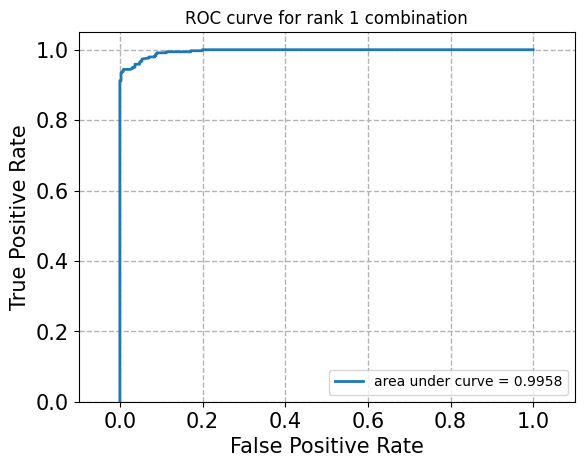

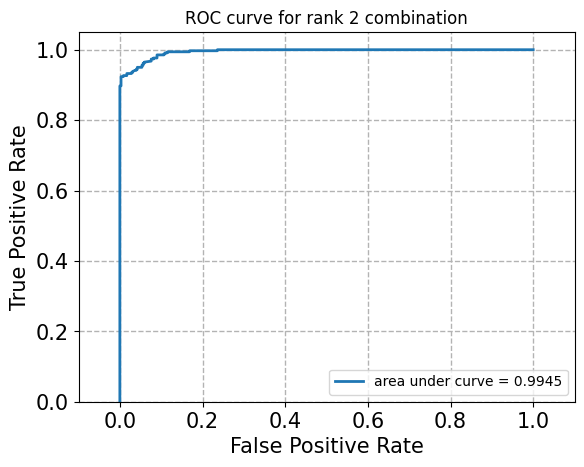

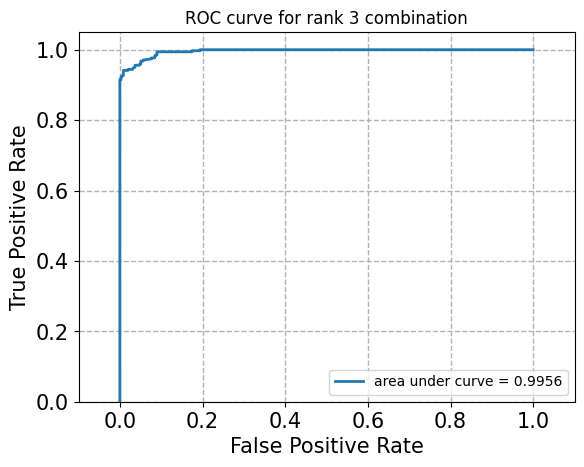

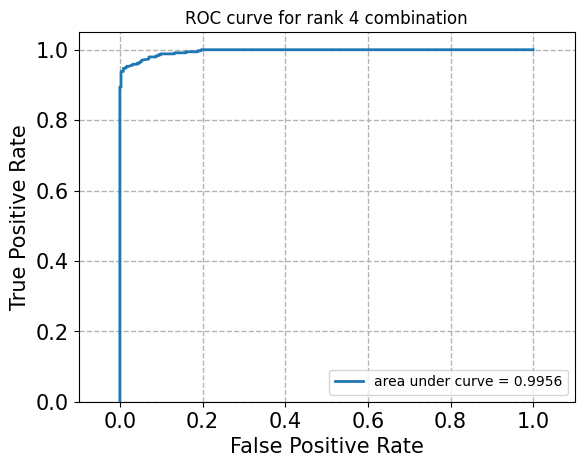

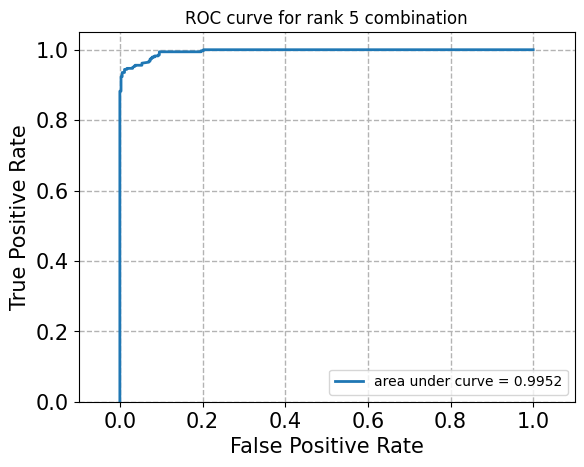

In [ ]:
# 5. Report performances on testing set

top_5_pipelines = [
    # 1
    Pipeline([
        ('vect', CountVectorizer(min_df=5, analyzer=stem_rmv_punc, stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', TruncatedSVD(n_components=100, random_state=42)),
        ('clf', LogisticRegression(penalty='l1', C=1/best_l1_reg_strength, solver='liblinear')),
    ]),

    # 2
    Pipeline([
        ('vect', CountVectorizer(min_df=5, analyzer=stem_rmv_punc, stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', NMF(n_components=100, init='random', random_state=42)),
        ('clf', LogisticRegression(penalty='l1', C=1/best_l1_reg_strength, solver='liblinear')),
    ]),

    # 3
    Pipeline([
        ('vect', CountVectorizer(min_df=2, analyzer=stem_rmv_punc, stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', TruncatedSVD(n_components=100, random_state=42)),
        ('clf', LogisticRegression(penalty='l1', C=1/best_l1_reg_strength, solver='liblinear')),
    ]),

    # 4
    Pipeline([
        ('vect', CountVectorizer(min_df=5, analyzer=stem_rmv_punc, stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', TruncatedSVD(n_components=100, random_state=42)),
        ('clf', LogisticRegression(penalty='l2', C=1/best_l2_reg_strength, solver='liblinear')),
    ]),

    # 5
    Pipeline([
        ('vect', CountVectorizer(min_df=2, analyzer=stem_rmv_punc, stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('reduce_dim', TruncatedSVD(n_components=100, random_state=42)),
        ('clf', LogisticRegression(penalty='l2', C=1/best_l2_reg_strength, solver='liblinear')),
    ]),
]

for i in range(len(top_5_pipelines)):
    fit_predict_and_show_stats(top_5_pipelines[i], train['full_text'], train['root_label'], test['full_text'], test['root_label'], f'rank {i+1} combination')

# Q9

In [ ]:
# Multiclass classification

# get correct data label
multiclass_train, multiclass_test = train_test_split(df[["full_text","leaf_label"]], test_size=0.2)

multiclass_train = multiclass_train.map(clean)
multiclass_test = multiclass_test.map(clean)

# ensure we go back to the original settings
# feature extraction: lemmatization, min_df=3
vectorizer = CountVectorizer(analyzer=stem_rmv_punc,
                             stop_words='english',
                             min_df=3)
multiclass_train_lemmatized = vectorizer.fit_transform(multiclass_train['full_text'])
multiclass_test_lemmatized = vectorizer.transform(multiclass_test['full_text'])

tfidf_transformer = TfidfTransformer()
multiclass_train_tfidf = tfidf_transformer.fit_transform(multiclass_train_lemmatized)
multiclass_test_tfidf = tfidf_transformer.transform(multiclass_test_lemmatized)

# dimensionality reduction: LSI, k=25
svd = TruncatedSVD(n_components=25, random_state=42)
multiclass_train_lsi = svd.fit_transform(multiclass_train_tfidf)
multiclass_test_lsi = svd.transform(multiclass_test_tfidf)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [ ]:
map_row_to_class = {0:"basketball", 1:"baseball", 2:"tennis",
                    3:"football", 4:"soccer", 5:"forest fire", 6:"flood",
                    7:"earthquake", 8:"drought", 9:"heatwave"}

class_labels = []
for i in range(10):
    class_labels.append(map_row_to_class[i])

print(class_labels)

['basketball', 'baseball', 'tennis', 'football', 'soccer', 'forest fire', 'flood', 'earthquake', 'drought', 'heatwave']


In [ ]:
def multiclass_fit_predict_and_show_stats(pipe, train_data, train_label, test_data, test_label, pipe_title):
    pipe.fit(train_data, train_label)
    predicted = pipe.predict(test_data)

    # Report stats
    print('----------')
    print(f"Stats for {pipe_title}")
    print(f"Confusion matrix: {confusion_matrix(test_label, predicted, labels=class_labels)}")
    print(f"Accuracy score: {accuracy_score(test_label, predicted)}")
    print(f"Recall score: {recall_score(test_label, predicted, average='micro')}")
    print(f"Precision score: {precision_score(test_label, predicted, average='micro')}")
    print(f"F1 score: {f1_score(test_label, predicted, average='micro')}")
    print('----------')
    print()

In [ ]:
# Naive Bayes
multiclass_nb_pipe = Pipeline([
    ('clf', GaussianNB()),
])

multiclass_fit_predict_and_show_stats(multiclass_nb_pipe,
                                      multiclass_train_lsi,
                                      multiclass_train['leaf_label'],
                                      multiclass_test_lsi,
                                      multiclass_test['leaf_label'],
                                      'multiclass naive bayes')

----------
Stats for multiclass naive bayes
Confusion matrix: [[49  4  1  5  1  0  0  0  0  0]
 [ 0 51  9  1  3  0  1  0  0  0]
 [ 0  7 58  0  2  0  2  0  1  2]
 [ 0  5  2 58  0  0  0  3  0  0]
 [ 0  8  9  0 64  0  0  0  0  3]
 [ 0  3  6  1  0 13  2  1  1 47]
 [ 0  1  1  0  0  5 62  0  1  1]
 [ 0  7  3  0  0  2  0 60  0  1]
 [ 0  0  2  0  0  0  1  1 54  4]
 [ 0  8  9  1  0 18  1  0  1 29]]
Accuracy score: 0.7155172413793104
Recall score: 0.7155172413793104
Precision score: 0.7155172413793104
F1 score: 0.7155172413793104
----------



In [ ]:
# Multiclass SVM (one vs one)
from sklearn.multiclass import OneVsOneClassifier

svc_model_one_v_one = SVC(kernel='linear', C=best_gamma, probability=True)
multiclass_svm_one_v_one = Pipeline([
    ('clf', OneVsOneClassifier(svc_model_one_v_one)),
])

multiclass_fit_predict_and_show_stats(multiclass_svm_one_v_one,
                                      multiclass_train_lsi,
                                      multiclass_train['leaf_label'],
                                      multiclass_test_lsi,
                                      multiclass_test['leaf_label'],
                                      'multiclass SVM (one vs one)')

----------
Stats for multiclass SVM (one vs one)
Confusion matrix: [[60  0  0  0  0  0  0  0  0  0]
 [ 1 57  3  2  0  0  1  1  0  0]
 [ 0  7 57  0  2  4  1  0  0  1]
 [ 3  1  1 61  0  2  0  0  0  0]
 [ 2  0  2  0 79  1  0  0  0  0]
 [ 0  0  1  0  0 29  1  0  3 40]
 [ 0  1  0  0  0  3 67  0  0  0]
 [ 0  2  2  0  0  2  0 66  0  1]
 [ 0  1  0  0  0  3  0  1 56  1]
 [ 0  2  1  0  0 39  0  3  2 20]]
Accuracy score: 0.7931034482758621
Recall score: 0.7931034482758621
Precision score: 0.7931034482758621
F1 score: 0.7931034482758621
----------



In [ ]:
# Multiclass SVM (one vs rest)
from sklearn.multiclass import OneVsRestClassifier

# class_weight='balanced' ensures automatic weight adjustment based on class frequencies
svc_model_one_v_rest = SVC(kernel='linear', C=best_gamma, probability=True, class_weight='balanced')
multiclass_svm_one_v_rest = Pipeline([
    ('clf', OneVsRestClassifier(svc_model_one_v_rest)),
])

multiclass_fit_predict_and_show_stats(multiclass_svm_one_v_rest,
                                      multiclass_train_lsi,
                                      multiclass_train['leaf_label'],
                                      multiclass_test_lsi,
                                      multiclass_test['leaf_label'],
                                      'multiclass SVM (one vs rest), balanced')

----------
Stats for multiclass SVM (one vs rest), balanced
Confusion matrix: [[60  0  0  0  0  0  0  0  0  0]
 [ 0 56  5  1  1  1  1  0  0  0]
 [ 0  7 56  1  4  2  0  0  0  2]
 [ 1  1  1 64  0  1  0  0  0  0]
 [ 1  1  2  0 80  0  0  0  0  0]
 [ 0  4  4  0  0 30  2  0  3 31]
 [ 0  1  0  0  0  2 67  1  0  0]
 [ 0  1  3  0  0  2  0 67  0  0]
 [ 0  2  0  0  0  2  0  1 56  1]
 [ 0  8  6  0  0 27  0  2  2 22]]
Accuracy score: 0.8017241379310345
Recall score: 0.8017241379310345
Precision score: 0.8017241379310345
F1 score: 0.8017241379310345
----------



In [ ]:
# Merging class 9 (heatwave) into class 5 (forest fire)
merged_train_leaf_label = [label if label != 'heatwave' else 'forest fire' for label in list(multiclass_train['leaf_label'])]
merged_test_leaf_label = [label if label != 'heatwave' else 'forest fire' for label in list(multiclass_test['leaf_label'])]

merged_class_labels = []
for i in range(9):
    merged_class_labels.append(map_row_to_class[i])

def merged_multiclass_fit_predict_and_show_stats(pipe, train_data, train_label, test_data, test_label, pipe_title):
    pipe.fit(train_data, train_label)
    predicted = pipe.predict(test_data)

    # Report stats
    print('----------')
    print(f"Stats for {pipe_title}")
    print(f"Confusion matrix: {confusion_matrix(test_label, predicted, labels=merged_class_labels)}")
    print(f"Accuracy score: {accuracy_score(test_label, predicted)}")
    print('----------')
    print()

In [ ]:
merged_multiclass_fit_predict_and_show_stats(multiclass_nb_pipe,
                                             multiclass_train_lsi,
                                             merged_train_leaf_label,
                                             multiclass_test_lsi,
                                             merged_test_leaf_label,
                                             'merged multiclass naive bayes')

merged_multiclass_fit_predict_and_show_stats(multiclass_svm_one_v_one,
                                             multiclass_train_lsi,
                                             merged_train_leaf_label,
                                             multiclass_test_lsi,
                                             merged_test_leaf_label,
                                             'merged multiclass SVM (one vs one)')
merged_multiclass_fit_predict_and_show_stats(multiclass_svm_one_v_rest,
                                             multiclass_train_lsi,
                                             merged_train_leaf_label,
                                             multiclass_test_lsi,
                                             merged_test_leaf_label,
                                             'merged multiclass SVM (one vs rest), balanced')

----------
Stats for merged multiclass naive bayes
Confusion matrix: [[ 49   4   1   5   1   0   0   0   0]
 [  0  51   9   1   3   0   1   0   0]
 [  0   7  58   0   2   2   2   0   1]
 [  0   5   2  58   0   0   0   3   0]
 [  0   8   9   0  64   3   0   0   0]
 [  0  11  13   2   0 110   2   1   2]
 [  0   1   1   0   0   6  62   0   1]
 [  0   6   3   0   0   4   0  60   0]
 [  0   0   2   0   0   7   1   0  52]]
Accuracy score: 0.8103448275862069
----------

----------
Stats for merged multiclass SVM (one vs one)
Confusion matrix: [[ 60   0   0   0   0   0   0   0   0]
 [  1  56   3   2   0   1   1   1   0]
 [  0   5  55   0   2   9   1   0   0]
 [  3   1   1  61   0   2   0   0   0]
 [  2   0   2   0  79   1   0   0   0]
 [  0   2   2   0   0 130   1   1   5]
 [  0   0   0   0   0   4  67   0   0]
 [  0   1   1   0   0   7   0  64   0]
 [  0   1   0   0   0   5   0   0  56]]
Accuracy score: 0.9022988505747126
----------

----------
Stats for merged multiclass SVM (one vs rest), b

In [ ]:
# Solving class imbalance in multiclass SVMs

balanced_svc_model_one_v_one = SVC(kernel='linear', C=best_gamma, probability=True, class_weight='balanced')
balanced_multiclass_svm_one_v_one = Pipeline([
    ('clf', OneVsOneClassifier(balanced_svc_model_one_v_one)),
])

# one v rest is already balanced, but we repeat them here too
balanced_svc_model_one_v_rest = SVC(kernel='linear', C=best_gamma, probability=True, class_weight='balanced')
balanced_multiclass_svm_one_v_rest = Pipeline([
    ('clf', OneVsRestClassifier(balanced_svc_model_one_v_rest)),
])

merged_multiclass_fit_predict_and_show_stats(balanced_multiclass_svm_one_v_one,
                                             multiclass_train_lsi,
                                             merged_train_leaf_label,
                                             multiclass_test_lsi,
                                             merged_test_leaf_label,
                                             'merged multiclass SVM (one vs one), balanced')
merged_multiclass_fit_predict_and_show_stats(balanced_multiclass_svm_one_v_rest,
                                             multiclass_train_lsi,
                                             merged_train_leaf_label,
                                             multiclass_test_lsi,
                                             merged_test_leaf_label,
                                             'merged multiclass SVM (one vs rest), balanced')

----------
Stats for merged multiclass SVM (one vs one), balanced
Confusion matrix: [[ 59   0   0   1   0   0   0   0   0]
 [  1  57   3   2   0   0   1   1   0]
 [  0   7  58   0   2   3   2   0   0]
 [  3   1   2  61   0   1   0   0   0]
 [  2   1   2   0  79   0   0   0   0]
 [  0   4   4   0   0 124   1   3   5]
 [  0   1   0   0   0   3  67   0   0]
 [  0   2   2   0   0   2   0  66   1]
 [  0   1   0   0   0   4   0   1  56]]
Accuracy score: 0.9008620689655172
----------

----------
Stats for merged multiclass SVM (one vs rest), balanced
Confusion matrix: [[ 60   0   0   0   0   0   0   0   0]
 [  0  56   5   1   1   1   1   0   0]
 [  0   6  56   1   2   6   0   1   0]
 [  1   1   2  64   0   0   0   0   0]
 [  1   1   2   0  80   0   0   0   0]
 [  0   9   9   0   0 116   1   2   4]
 [  0   1   0   0   0   4  66   0   0]
 [  0   1   3   0   0   2   0  67   0]
 [  0   1   0   0   0   4   0   1  56]]
Accuracy score: 0.8922413793103449
----------



# Q11

In [ ]:
# Download and use GLoVE

# !wget http://nlp.stanford.edu/data/glove.6B.zip

# if the link doesn't work
!wget https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
!unzip glove*.zip

--2025-01-24 21:47:20--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
Resolving huggingface.co (huggingface.co)... 3.167.112.38, 3.167.112.45, 3.167.112.25, ...
Connecting to huggingface.co (huggingface.co)|3.167.112.38|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/stanfordnlp/glove/6471382cdd837544bf3ac72497a38715e845897d265b2b424b4761832009c837?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27glove.6B.zip%3B+filename%3D%22glove.6B.zip%22%3B&response-content-type=application%2Fzip&Expires=1737758840&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNzc1ODg0MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9zdGFuZm9yZG5scC9nbG92ZS82NDcxMzgyY2RkODM3NTQ0YmYzYWM3MjQ5N2EzODcxNWU4NDU4OTdkMjY1YjJiNDI0YjQ3NjE4MzIwMDljODM3P3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=CFCWGK8RVZ%7ESlFIyRPlX97Wl-nLCuZxZ4lJ2qUwbYhc8V8typ5KT

In [ ]:
embeddings_dict = {}
dimension_of_glove = 300
with open("glove.6B.300d.txt", 'r') as f: # if 'r' fails, please use 'rb'
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [ ]:
# binary classification
train, test = train_test_split(df[["full_text", "root_label"]], test_size=0.2)

train = train.map(clean)
test = test.map(clean)

In [ ]:
# lemmatization on strings
def lemmatize_sent_string(text):
    list_word = text.split(' ')
    for i in range(len(list_word)-1, -1, -1):
        if is_all_numbers(list_word[i]):
            del list_word[i]
        else:
            new = ''
            for char in list_word[i]:
                if char.isalpha():
                    new += char
            list_word[i] = new.lower()

    return ' '.join([wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
            for word, tag in pos_tag(list_word)])

train_lemmatized = train['full_text'].apply(lemmatize_sent_string)
test_lemmatized = test['full_text'].apply(lemmatize_sent_string)

In [ ]:
# create a transformer for glove
# based on https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html#Train-a-classifier-on-the-sentence-embeddings

class Word2VecVectorizer:
    def __init__(self, embeddings_dict, dimension):
        self.embeddings_dict = embeddings_dict
        self.dimension = dimension

    def fit(self, data):
        pass

    def transform(self, data):
        X = np.zeros((data.shape[0], self.dimension))
        n = 0
        for sentence in data:
            tokens = sentence.split()
            vectors = []
            for word in tokens:
                vector = self.embeddings_dict.get(word)
                if vector is not None:
                    vectors.append(vector)
            if len(vectors) != 0:
                vectors = np.array(vectors)
                X[n] = vectors.mean(axis=0)
            n += 1
        return X

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [ ]:
glove_vectorizer = Word2VecVectorizer(embeddings_dict, dimension_of_glove)

train_glove = glove_vectorizer.fit_transform(train_lemmatized)
test_glove = glove_vectorizer.transform(test_lemmatized)

print(train_glove.shape)
print(test_glove.shape)

(2780, 300)
(696, 300)


----------
Stats for L1 logistic regression with LSI dimensionality reduction and GLoVE embeddings
Confusion matrix: [[341  25]
 [ 20 310]]
Accuracy score: 0.9353448275862069
Recall score: 0.9393939393939394
Precision score: 0.9253731343283582
F1 score: 0.9323308270676691
----------



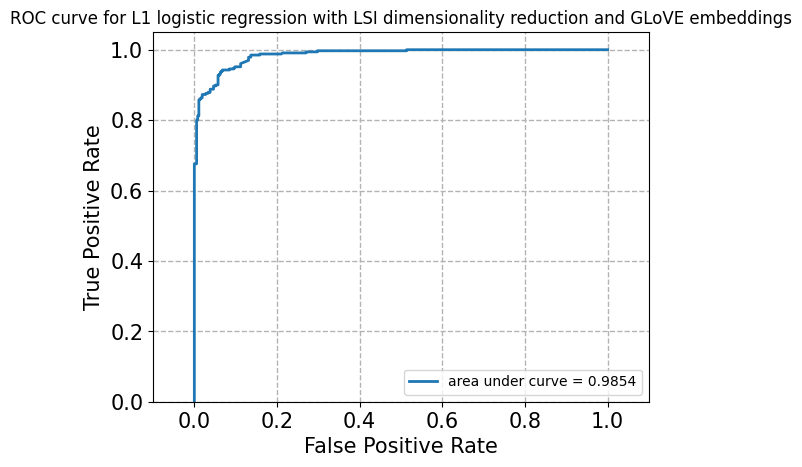

In [ ]:
pipeline = Pipeline([
    ('reduce_dim', TruncatedSVD(n_components=25, random_state=42)),
    ('clf', LogisticRegression(penalty='l1', C=1/best_l1_reg_strength, solver='liblinear', max_iter=500)),
])

fit_predict_and_show_stats(pipeline, train_glove, train['root_label'], test_glove, test['root_label'],
                           'L1 logistic regression with LSI dimensionality reduction and GLoVE embeddings')

# Q12

In [ ]:
embeddings_dicts = [{}, {}, {}, {}]
dimensions_of_glove = [50, 100, 200, 300]
accuracies = []

pipeline = Pipeline([
    ('reduce_dim', TruncatedSVD(n_components=25, random_state=42)),
    ('clf', LogisticRegression(penalty='l1', C=1/best_l1_reg_strength, solver='liblinear', max_iter=500)),
])

for i in range(len(dimensions_of_glove)):
    dimension = dimensions_of_glove[i]
    with open(f"glove.6B.{dimension}d.txt", 'r') as f: # if 'r' fails, please use 'rb'
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dicts[i][word] = vector

    glove_vectorizer = Word2VecVectorizer(embeddings_dicts[i], dimension)
    train_glove = glove_vectorizer.fit_transform(train_lemmatized)
    test_glove = glove_vectorizer.transform(test_lemmatized)

    print(f"Dimension: {dimension}")

    pipeline.fit(train_glove, train['root_label'])
    predicted = pipeline.predict(test_glove)
    accuracy = accuracy_score(test['root_label'], predicted)
    print(f"Accuracy score: {accuracy}")
    accuracies.append(accuracy)

    print("--------\n")

Dimension: 50
Accuracy score: 0.9295977011494253
--------

Dimension: 100
Accuracy score: 0.9267241379310345
--------

Dimension: 200
Accuracy score: 0.9310344827586207
--------

Dimension: 300
Accuracy score: 0.9353448275862069
--------



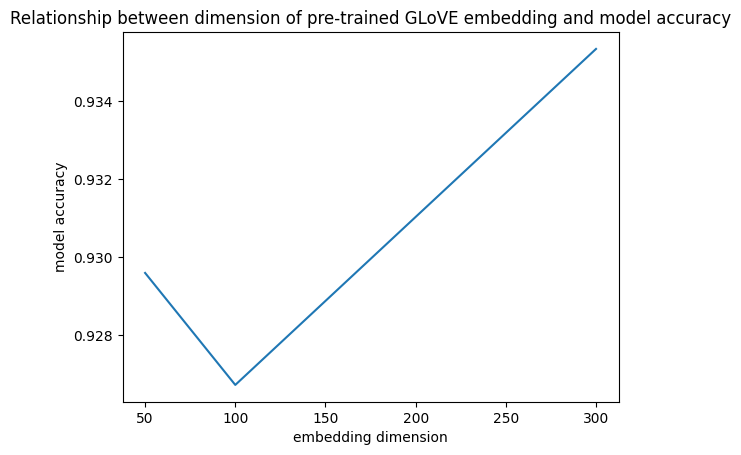

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

plt.plot(dimensions_of_glove, accuracies)
plt.title('Relationship between dimension of pre-trained GLoVE embedding and model accuracy')
plt.xlabel('embedding dimension')
plt.ylabel('model accuracy')
plt.show()

# Q13

In [ ]:
# Install umap
!pip install umap-learn
!pip install umap-learn[plot]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 73.7 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn

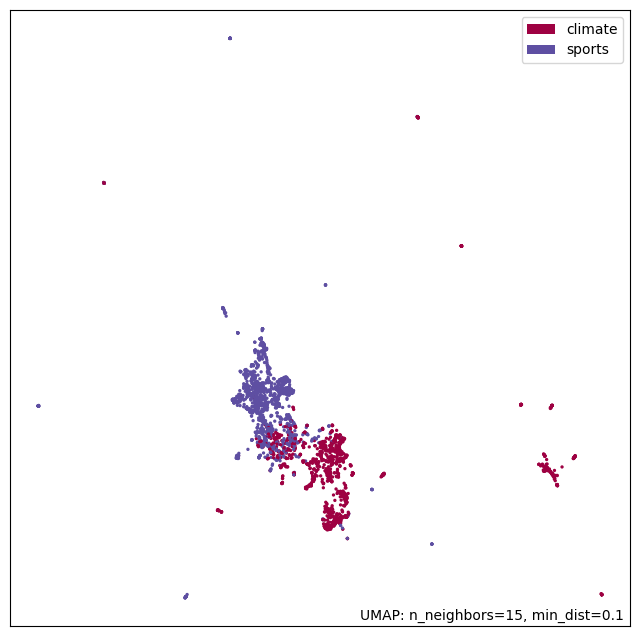

In [ ]:
import umap
import umap.plot

# visualize GLoVE embeddings
vis = umap.UMAP(metric='euclidean').fit(train_glove)
fig = umap.plot.points(vis, labels=train['root_label'])

(2780, 300)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


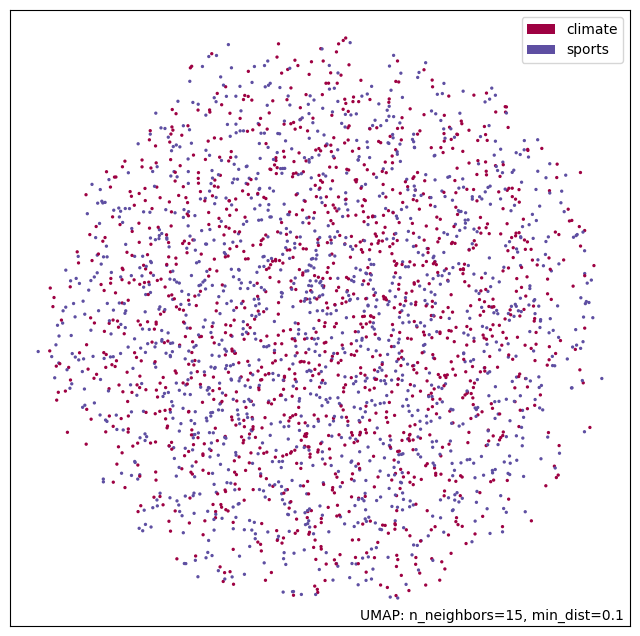

In [ ]:
# generate normalized random vectors
random_matrix = np.random.normal(0, 1, train_glove.shape)
print(random_matrix.shape)

# visualize normalized random vectors
vis_rand = umap.UMAP(metric='euclidean').fit(random_matrix)
fig = umap.plot.points(vis_rand, labels=train['root_label'])